# Import Library

In [ ]:
# Install required libraries (if not already installed)
!pip install "huggingface_hub[hf_xet]" -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 19.9 MB/s eta 0:00:00


In [ ]:

# ==================== Import Libraries ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import random
import gc
import itertools
import pandas as pd
import torch
import copy
import pickle


from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix
)

from wordcloud import WordCloud
from tqdm import tqdm
from scipy.sparse import csr_matrix
from xgboost import XGBClassifier

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import (
    BertTokenizer, BertModel,
    AutoTokenizer, AutoModelForSeq2SeqLM,
    pipeline
)
# ==================== Runtime Initialization ====================
# Garbage collection and clear GPU cache
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
# ==================== Set Device ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==================== Set Random Seed ====================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda


# Data Loading

In [ ]:
#for google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read Spam_SMS.csv
file_path = "/content/drive/My Drive/Spam SMS/Spam_SMS.csv"
df = pd.read_csv(file_path)

# Preview the merged data
print("\nPreview of the merged data:")
print(df.head())


Preview of the merged data:
  Class                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


# Data Clean

In [ ]:
df.shape

(5574, 2)

In [ ]:
df.isnull().sum()

,0
Class,0
Message,0


In [ ]:
df.duplicated().sum()

np.int64(415)

In [ ]:
df = df.drop_duplicates(keep="first")

In [ ]:
df.shape

(5159, 2)

### data augmentation

In [ ]:
# Load the pretrained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ramsrigouthamg/t5_paraphraser")
model = AutoModelForSeq2SeqLM.from_pretrained("ramsrigouthamg/t5_paraphraser").to(device)

# Batch paraphrasing function
def paraphrase_batch(texts, batch_size=8):
    paraphrased_outputs = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        inputs = ["paraphrase: " + text + " </s>" for text in batch]
        encoding = tokenizer.batch_encode_plus(
            inputs,
            padding="longest",
            return_tensors="pt",
            truncation=True,
            max_length=256
        )

        input_ids = encoding["input_ids"].to(device)
        attention_masks = encoding["attention_mask"].to(device)

        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_masks,
            max_length=256,
            do_sample=True,
            top_k=120,
            top_p=0.95,
            early_stopping=True,
            num_return_sequences=1
        )

        batch_outputs = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        paraphrased_outputs.extend(batch_outputs)

    return paraphrased_outputs

# Assume df is already loaded and contains a column named "Message"
texts = df["Message"].tolist()

# Generate paraphrased texts
paraphrased_texts = paraphrase_batch(texts, batch_size=16)

# Ensure the number of paraphrased texts matches the original
if len(paraphrased_texts) != len(texts):
    raise ValueError("Mismatch between original and paraphrased text count.")

# Add the paraphrased texts back to a copy of the original DataFrame
df_aug = df.copy()
df_aug["Message"] = paraphrased_texts

# Concatenate the original and augmented data
df = pd.concat([df, df_aug], ignore_index=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]


  0%|          | 0/323 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(

100%|██████████| 323/323 [08:06<00:00,  1.51s/it]


# Exploratory Data Analysis (EDA)

## Class Distribution

In [ ]:
# Data set size
N_SAMPLES = len(df)

print(f"Total Number of Samples : {N_SAMPLES}")

Total Number of Samples : 5159


In [ ]:
class_counts = df["Class"].value_counts()
class_ratios = class_counts / N_SAMPLES

<ipython-input-15-e3b081676ef2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Class", data=df, palette="Set2")


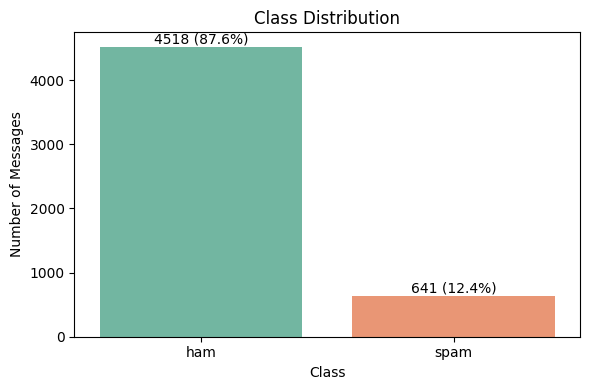

In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="Class", data=df, palette="Set2")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Messages")

for p in ax.patches:
    count = int(p.get_height())
    ratio = count / N_SAMPLES
    ax.annotate(f'{count} ({ratio:.1%})',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

##  Message Length

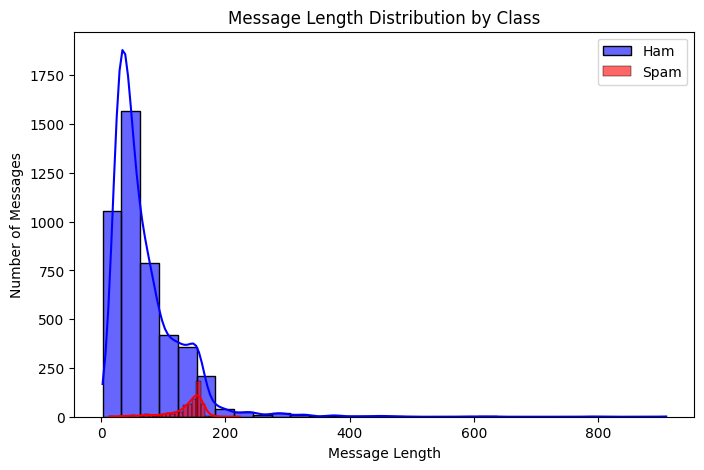

In [ ]:
df["text_length"] = df["Message"].apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(df[df["Class"] == "ham"]["text_length"], bins=30, color="blue", label="Ham", kde=True, alpha=0.6)
sns.histplot(df[df["Class"] == "spam"]["text_length"], bins=30, color="red", label="Spam", kde=True, alpha=0.6)
plt.legend()
plt.title("Message Length Distribution by Class")
plt.xlabel("Message Length")
plt.ylabel("Number of Messages")
plt.show()


In [ ]:
max_len = max([len(text) for text in df.Message])
print(f"Maximum Length Of Input Sequence(Chars) : {max_len}")

Maximum Length Of Input Sequence(Chars) : 910


## Word Cloud

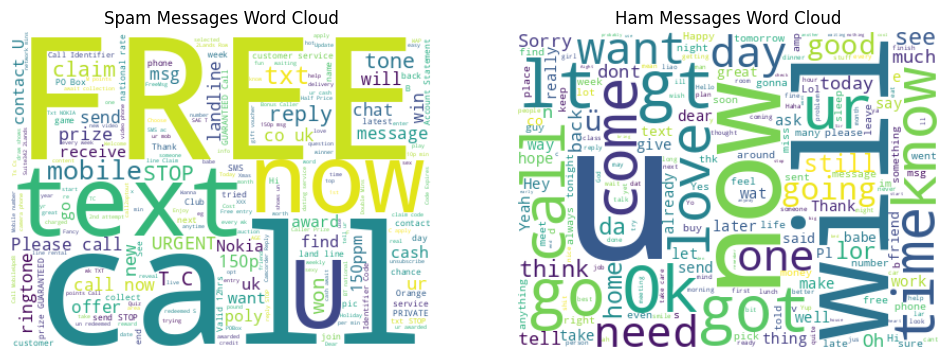

In [ ]:
spam_words = " ".join(df[df["Class"] == "spam"]['Message'])
ham_words = " ".join(df[df["Class"] == "ham"]['Message'])

plt.figure(figsize=(12, 5))

# Spam
plt.subplot(1, 2, 1)
spam_wordcloud = WordCloud(width=400, height=300, background_color="white").generate(spam_words)
plt.imshow(spam_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Spam Messages Word Cloud")

# Ham
plt.subplot(1, 2, 2)
ham_wordcloud = WordCloud(width=400, height=300, background_color="white").generate(ham_words)
plt.imshow(ham_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Ham Messages Word Cloud")

plt.show()


# Text Preprocessing

In [ ]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation

    if text is None:
        return ""  # Return an empty string if the text is None
    else:
        return text

df["clean_text"] = df["Message"].apply(clean_text)

# Encode target variable
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Class"])  # spam = 1, ham = 0

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# TF-IDF feature extraction (Don't delete this!!! Both Random Forest and LSTM use this!!! Do not remove!!!)
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

import pickle

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# SVM

In [ ]:
# function to plot confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap='Blues',
                          normalize=True):

    # Calculate accuracy and misclassification rate
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Labels for the x and y axes
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45, fontsize=12)
    plt.yticks(tick_marks, target_names, fontsize=12)

    # Normalize the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the values inside the matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.4f}" if normalize else f"{cm[i, j]:,}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=14)

    # Set labels for the axes and title
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)

    # Display accuracy and misclassification rate in the title
    plt.title(f'{title}\nAccuracy={accuracy:.4f}; Misclassification={misclass:.4f}', fontsize=16)

    plt.tight_layout()
    plt.show()

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best SVM Parameters:
 {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}

SVM Classification Report(On Test Set):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1808
           1       0.89      0.89      0.89       256

    accuracy                           0.97      2064
   macro avg       0.94      0.94      0.94      2064
weighted avg       0.97      0.97      0.97      2064

SVM Accuracy: 0.9729
SVM Precision: 0.8876
SVM Recall: 0.8945
SVM F1 Score: 0.8911
SVM ROC AUC: 0.9851


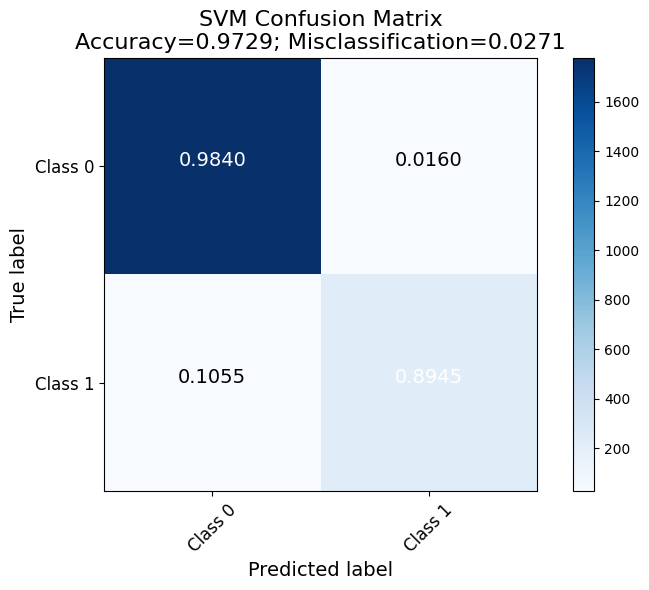

In [ ]:
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'class_weight': ['balanced']
}


svm = SVC(probability=True, random_state=42)
grid_search_svm = GridSearchCV(estimator=svm,
                                param_grid=svm_param_grid,
                                scoring='f1',
                                cv=5,
                                n_jobs=-1,
                                verbose=1)


grid_search_svm.fit(X_train_tfidf, y_train)
best_svm = grid_search_svm.best_estimator_
print("Best SVM Parameters:\n", grid_search_svm.best_params_)


y_pred = best_svm.predict(X_test_tfidf)
y_probs = best_svm.decision_function(X_test_tfidf)


print("\nSVM Classification Report(On Test Set):")
print(classification_report(y_test, y_pred))

# Additional Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)

print(f"SVM Accuracy: {accuracy:.4f}")
print(f"SVM Precision: {precision:.4f}")
print(f"SVM Recall: {recall:.4f}")
print(f"SVM F1 Score: {f1:.4f}")
print(f"SVM ROC AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=["Class 0", "Class 1"], title="SVM Confusion Matrix", normalize=True)

# Random Forest

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters:
 {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Random Forest Classification Report(On Test Set):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1808
           1       0.95      0.82      0.88       256

    accuracy                           0.97      2064
   macro avg       0.97      0.91      0.93      2064
weighted avg       0.97      0.97      0.97      2064

Accuracy: 0.9734
Precision: 0.9548
Recall: 0.8242
F1 Score: 0.8847
ROC AUC: 0.9802


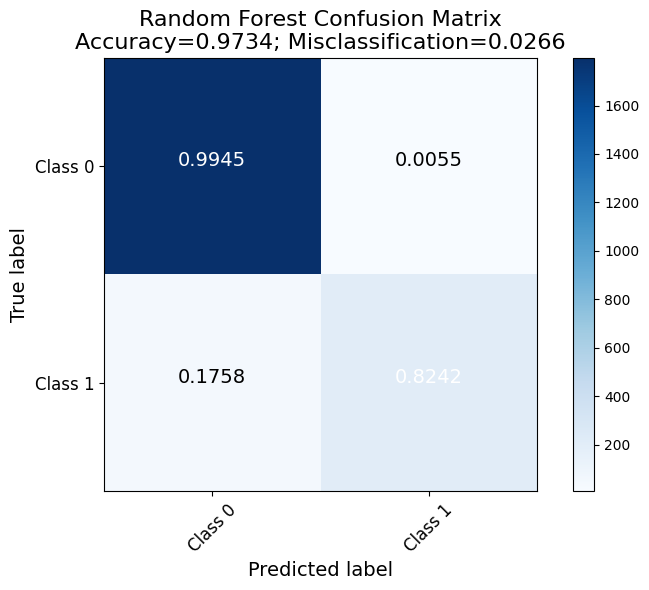

In [ ]:
set_seed(42)

with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# function to plot confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap='Blues',
                          normalize=True):

    # Calculate accuracy and misclassification rate
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Labels for the x and y axes
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45, fontsize=12)
    plt.yticks(tick_marks, target_names, fontsize=12)

    # Normalize the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the values inside the matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.4f}" if normalize else f"{cm[i, j]:,}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=14)

    # Set labels for the axes and title
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)

    # Display accuracy and misclassification rate in the title
    plt.title(f'{title}\nAccuracy={accuracy:.4f}; Misclassification={misclass:.4f}', fontsize=16)

    plt.tight_layout()
    plt.show()


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}


rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)


grid_search.fit(X_train_tfidf, y_train)
best_rf = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)


best_rf.fit(X_train_tfidf, y_train)


y_pred = best_rf.predict(X_test_tfidf)
rf_probs = best_rf.predict_proba(X_test_tfidf)[:, 1]


print("\nRandom Forest Classification Report(On Test Set):")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, rf_probs)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=["Class 0", "Class 1"], title="Random Forest Confusion Matrix", normalize=True)

# LSTM


Fold 1
Epoch 1/5, Loss: 0.5853
Epoch 2/5, Loss: 0.1378
Epoch 3/5, Loss: 0.0644
Epoch 4/5, Loss: 0.0388
Epoch 5/5, Loss: 0.0254

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2410
           1       0.92      0.87      0.89       342

    accuracy                           0.97      2752
   macro avg       0.95      0.93      0.94      2752
weighted avg       0.97      0.97      0.97      2752

Accuracy: 0.9742
Precision: 0.9195
Recall: 0.8684
F1 Score: 0.8932
ROC AUC: 0.9843


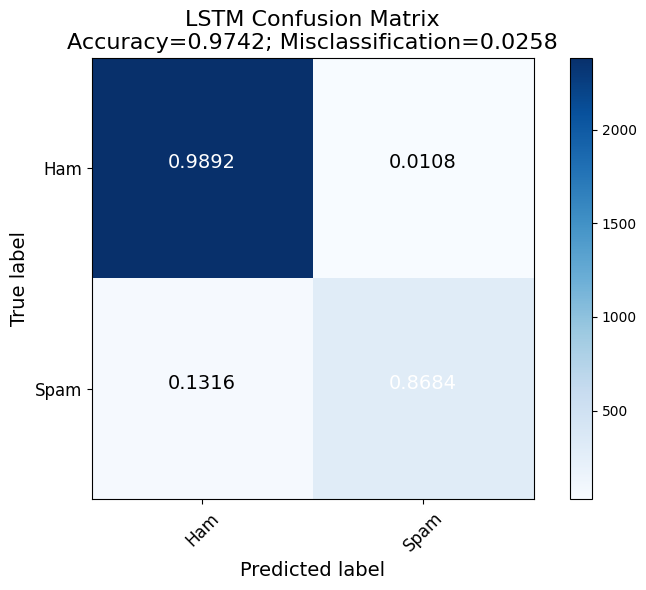

Fold 1 F1: 0.8932330827067669

Fold 2
Epoch 1/5, Loss: 0.5792
Epoch 2/5, Loss: 0.1373
Epoch 3/5, Loss: 0.0658
Epoch 4/5, Loss: 0.0402
Epoch 5/5, Loss: 0.0259

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2409
           1       0.87      0.89      0.88       342

    accuracy                           0.97      2751
   macro avg       0.92      0.93      0.93      2751
weighted avg       0.97      0.97      0.97      2751

Accuracy: 0.9687
Precision: 0.8657
Recall: 0.8860
F1 Score: 0.8757
ROC AUC: 0.9807


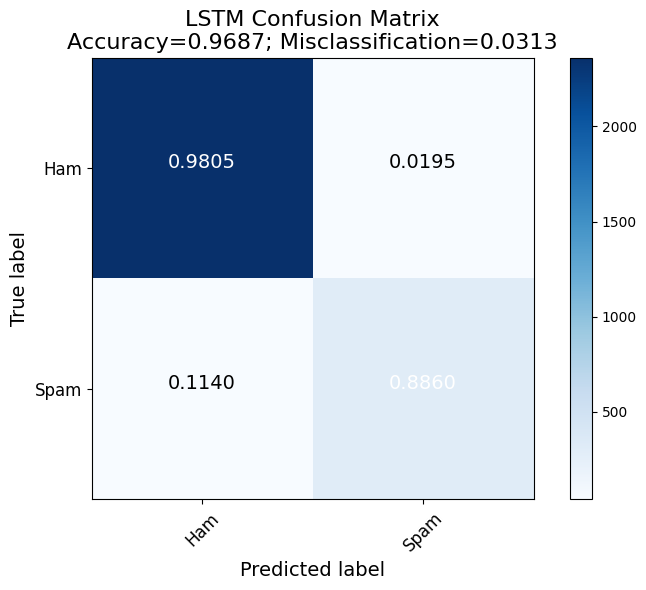

Fold 2 F1: 0.8757225433526011

Fold 3
Epoch 1/5, Loss: 0.5879
Epoch 2/5, Loss: 0.1368
Epoch 3/5, Loss: 0.0631
Epoch 4/5, Loss: 0.0351
Epoch 5/5, Loss: 0.0212

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2409
           1       0.85      0.88      0.87       342

    accuracy                           0.97      2751
   macro avg       0.92      0.93      0.92      2751
weighted avg       0.97      0.97      0.97      2751

Accuracy: 0.9662
Precision: 0.8507
Recall: 0.8830
F1 Score: 0.8666
ROC AUC: 0.9796


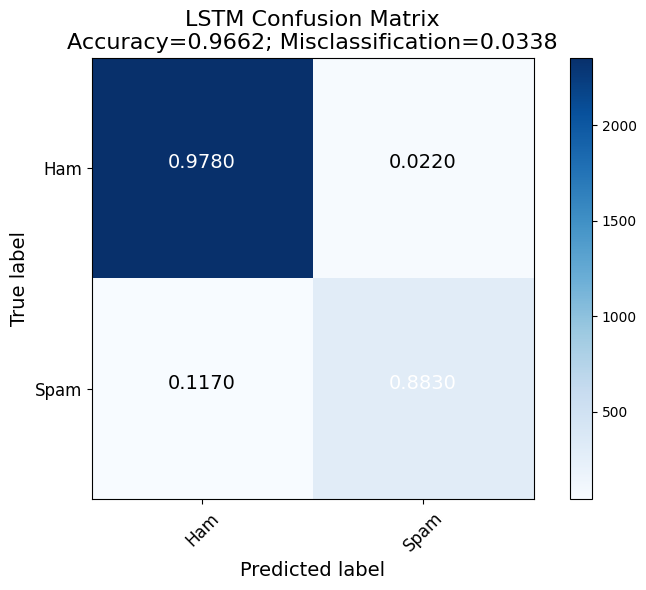

Fold 3 F1: 0.866571018651363

Training best model on full training data
Epoch 1/5, Loss: 0.4826
Epoch 2/5, Loss: 0.1096
Epoch 3/5, Loss: 0.0561
Epoch 4/5, Loss: 0.0321
Epoch 5/5, Loss: 0.0215

Final Evaluation on Test Set:

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1808
           1       0.86      0.88      0.87       256

    accuracy                           0.97      2064
   macro avg       0.92      0.93      0.93      2064
weighted avg       0.97      0.97      0.97      2064

Accuracy: 0.9680
Precision: 0.8626
Recall: 0.8828
F1 Score: 0.8726
ROC AUC: 0.9820


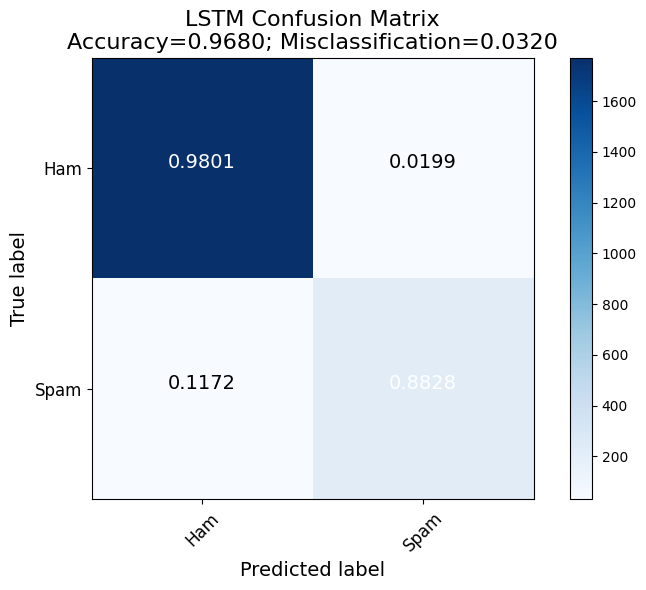

In [ ]:
with open("lstm_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


if isinstance(X_train_tfidf, csr_matrix):
    X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
elif not isinstance(X_train_tfidf, torch.Tensor):
    X_train_tfidf = torch.tensor(X_train_tfidf, dtype=torch.float32)

if isinstance(X_test_tfidf, csr_matrix):
    X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
elif not isinstance(X_test_tfidf, torch.Tensor):
    X_test_tfidf = torch.tensor(X_test_tfidf, dtype=torch.float32)

if not isinstance(y_train, torch.Tensor):
    y_train = torch.tensor(y_train.values, dtype=torch.long)
if not isinstance(y_test, torch.Tensor):
    y_test = torch.tensor(y_test.values, dtype=torch.long)


X_train_tfidf, y_train = X_train_tfidf.to(device), y_train.to(device)
X_test_tfidf, y_test = X_test_tfidf.to(device), y_test.to(device)


class_counts = torch.bincount(y_train)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap='Blues',
                          normalize=True):

    # Calculate accuracy and misclassification rate
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Labels for the x and y axes
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45, fontsize=12)
    plt.yticks(tick_marks, target_names, fontsize=12)

    # Normalize the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the values inside the matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.4f}" if normalize else f"{cm[i, j]:,}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=14)

    # Set labels for the axes and title
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)

    # Display accuracy and misclassification rate in the title
    plt.title(f'{title}\nAccuracy={accuracy:.4f}; Misclassification={misclass:.4f}', fontsize=16)

    plt.tight_layout()
    plt.show()


class SpamHamLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(SpamHamLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

def evaluate_model(model, test_loader, return_f1=False):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print("\nLSTM Classification Report:")
    print(classification_report(all_labels, all_preds))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, target_names=["Ham", "Spam"], title="LSTM Confusion Matrix", normalize=True)


    if return_f1:
        return f1


input_size = X_train_tfidf.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 5
learning_rate = 0.001
batch_size = 64



kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
best_f1 = 0
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tfidf.cpu(), y_train.cpu())):
    print(f"\nFold {fold+1}")
    X_train_fold, X_val_fold = X_train_tfidf[train_idx], X_train_tfidf[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = SpamHamLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=batch_size, shuffle=False)

    train_model(model, train_loader, criterion, optimizer, num_epochs)
    f1 = evaluate_model(model, val_loader, return_f1=True)

    print(f"Fold {fold+1} F1: {f1}")

    if f1 > best_f1:
        best_f1 = f1
        best_model_lstm = copy.deepcopy(model)


print("\nTraining best model on full training data")
best_model_lstm = SpamHamLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = optim.Adam(best_model_lstm.parameters(), lr=learning_rate)

train_loader = DataLoader(TensorDataset(X_train_tfidf, y_train), batch_size=batch_size, shuffle=True)
train_model(best_model_lstm, train_loader, criterion, optimizer, num_epochs)


test_dataset = TensorDataset(X_test_tfidf, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print("\nFinal Evaluation on Test Set:")
evaluate_model(best_model_lstm, test_loader, return_f1=False)


def get_lstm_probs(model, X_tensor, batch_size=64):
    model.eval()
    all_probs = []


    dummy_labels = torch.zeros(X_tensor.size(0), dtype=torch.long)
    loader = DataLoader(TensorDataset(X_tensor, dummy_labels), batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for X_batch, _ in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_probs)

# Bert

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Fold 1


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/3, Loss: 0.2325
Epoch 2/3, Loss: 0.0685
Epoch 3/3, Loss: 0.0354

BERT Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2410
           1       0.92      0.94      0.93       342

    accuracy                           0.98      2752
   macro avg       0.95      0.97      0.96      2752
weighted avg       0.98      0.98      0.98      2752

Accuracy: 0.9826
Precision: 0.9176
Recall: 0.9444
F1 Score: 0.9308
ROC AUC: 0.9911


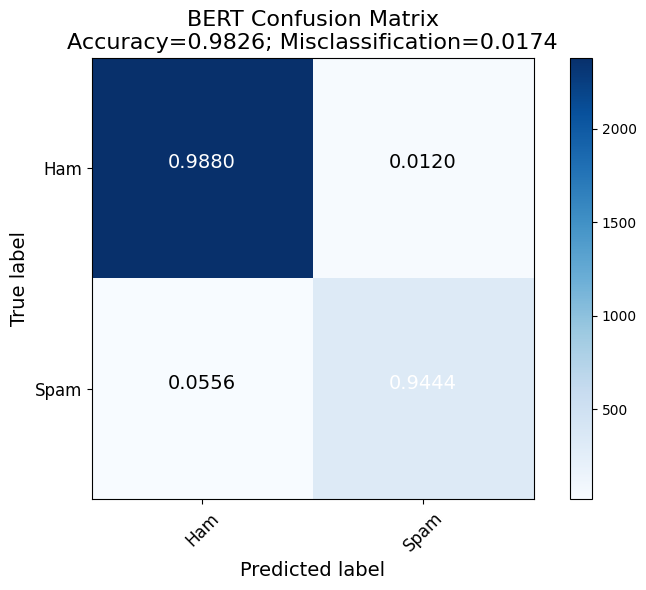


Fold 2
Epoch 1/3, Loss: 0.2237
Epoch 2/3, Loss: 0.0775
Epoch 3/3, Loss: 0.0316

BERT Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2409
           1       0.89      0.92      0.91       342

    accuracy                           0.98      2751
   macro avg       0.94      0.95      0.95      2751
weighted avg       0.98      0.98      0.98      2751

Accuracy: 0.9764
Precision: 0.8901
Recall: 0.9240
F1 Score: 0.9067
ROC AUC: 0.9833


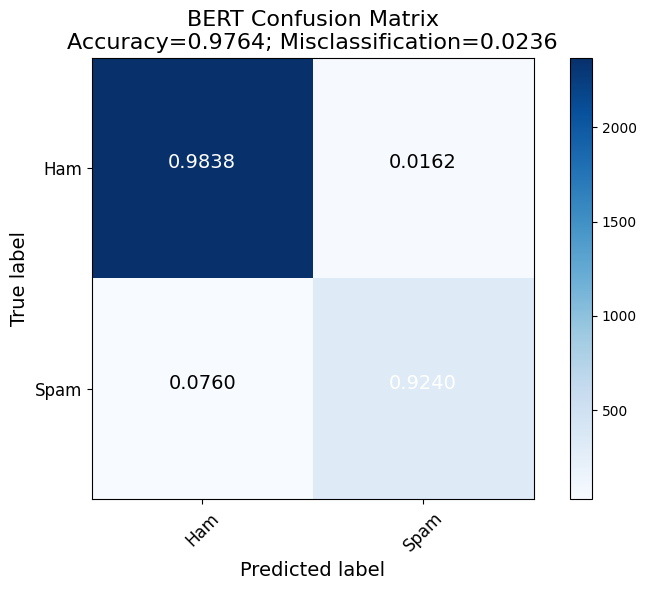


Fold 3
Epoch 1/3, Loss: 0.2312
Epoch 2/3, Loss: 0.0888
Epoch 3/3, Loss: 0.0420

BERT Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2409
           1       0.88      0.95      0.91       342

    accuracy                           0.98      2751
   macro avg       0.94      0.96      0.95      2751
weighted avg       0.98      0.98      0.98      2751

Accuracy: 0.9771
Precision: 0.8780
Recall: 0.9474
F1 Score: 0.9114
ROC AUC: 0.9876


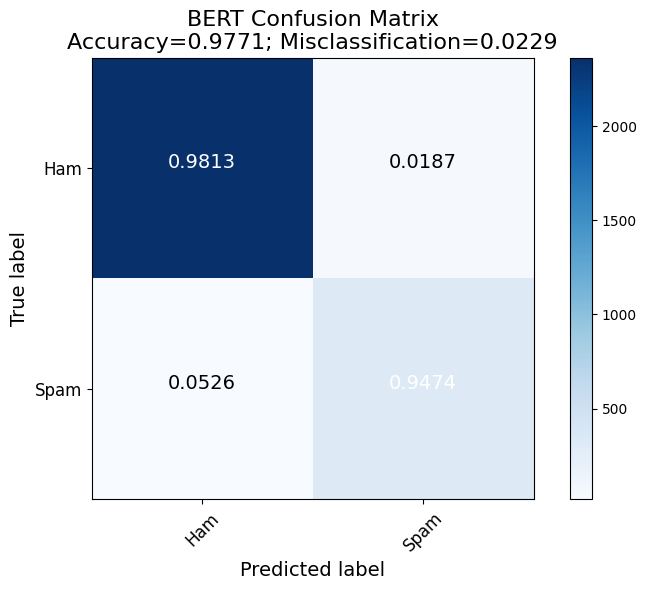


Training on full training data
Epoch 1/3, Loss: 0.0491
Epoch 2/3, Loss: 0.0504
Epoch 3/3, Loss: 0.0498


In [ ]:
torch.cuda.empty_cache()

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

if isinstance(X_train, torch.Tensor):
    X_train = X_train.cpu().numpy()
if isinstance(y_train, torch.Tensor):
    y_train = y_train.cpu().numpy()
if isinstance(X_test, torch.Tensor):
    X_test = X_test.cpu().numpy()
if isinstance(y_test, torch.Tensor):
    y_test = y_test.cpu().numpy()


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap='Blues',
                          normalize=True):

    # Calculate accuracy and misclassification rate
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Labels for the x and y axes
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45, fontsize=12)
    plt.yticks(tick_marks, target_names, fontsize=12)

    # Normalize the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the values inside the matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.4f}" if normalize else f"{cm[i, j]:,}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=14)

    # Set labels for the axes and title
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)

    # Display accuracy and misclassification rate in the title
    plt.title(f'{title}\nAccuracy={accuracy:.4f}; Misclassification={misclass:.4f}', fontsize=16)

    plt.tight_layout()
    plt.show()


class BertForSpamClassification(nn.Module):
    def __init__(self, num_classes=2):
        super(BertForSpamClassification, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        x = self.fc(x)
        return x


def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for input_ids, attention_mask, labels in train_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')


def evaluate_model(model, test_loader, return_f1=False):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print("\nBERT Classification Report:")
    print(classification_report(all_labels, all_preds))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, target_names=["Ham", "Spam"], title="BERT Confusion Matrix", normalize=True)

    if return_f1:
        return f1


num_classes = 2
num_epochs = 3
learning_rate = 2e-5
batch_size = 16


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
best_f1 = 0
best_model = None


X_train = np.array(X_train)
y_train = np.array(y_train)


for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\nFold {fold+1}")

    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]


    train_encodings = tokenizer(X_train_fold.tolist(), padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    val_encodings = tokenizer(X_val_fold.tolist(), padding='max_length', truncation=True, max_length=128, return_tensors='pt')


    train_input_ids = train_encodings['input_ids'].to(device)
    train_attention_mask = train_encodings['attention_mask'].to(device)
    train_labels = torch.tensor(y_train_fold, dtype=torch.long).to(device)

    val_input_ids = val_encodings['input_ids'].to(device)
    val_attention_mask = val_encodings['attention_mask'].to(device)
    val_labels = torch.tensor(y_val_fold, dtype=torch.long).to(device)


    train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    model = BertForSpamClassification(num_classes).to(device)


    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)


    train_model(model, train_loader, criterion, optimizer, num_epochs)
    f1 = evaluate_model(model, val_loader, return_f1=True)


    if f1 > best_f1:
        best_f1 = f1
        best_model_bert = copy.deepcopy(model)


print("\nTraining on full training data")
train_encodings = tokenizer(X_train.tolist(), padding='max_length', truncation=True, max_length=128, return_tensors='pt')
train_loader = DataLoader(TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train, dtype=torch.long)), batch_size=batch_size, shuffle=True)
train_model(best_model_bert, train_loader, criterion, optimizer, num_epochs)


Evaluating on test set

BERT Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1808
           1       0.89      0.93      0.91       256

    accuracy                           0.98      2064
   macro avg       0.94      0.95      0.95      2064
weighted avg       0.98      0.98      0.98      2064

Accuracy: 0.9763
Precision: 0.8876
Recall: 0.9258
F1 Score: 0.9063
ROC AUC: 0.9886


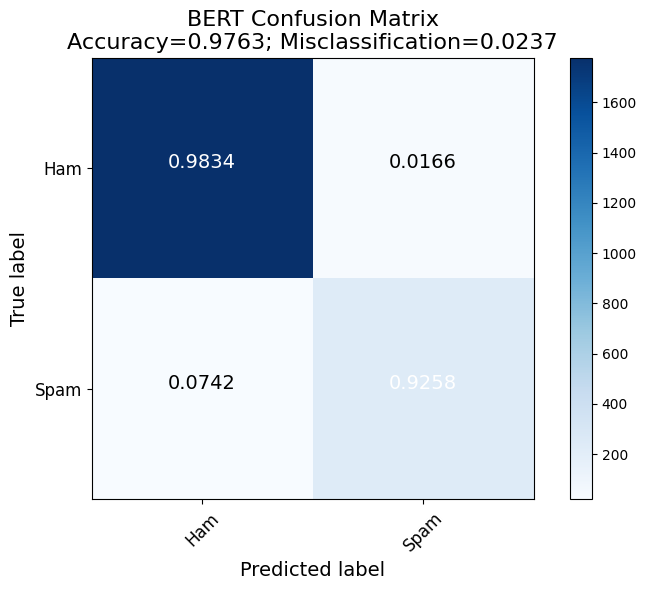

In [ ]:
print("\nEvaluating on test set")
test_encodings = tokenizer(X_test.tolist(), padding='max_length', truncation=True, max_length=128, return_tensors='pt')

assert test_encodings['input_ids'].shape[0] == test_encodings['attention_mask'].shape[0] == len(y_test), \
    f"Dimension mismatch: {test_encodings['input_ids'].shape}, {test_encodings['attention_mask'].shape}, {len(y_test)}"


test_loader = DataLoader(
    TensorDataset(
        test_encodings['input_ids'],
        test_encodings['attention_mask'],
        torch.tensor(y_test, dtype=torch.long) # .values
    ),
    batch_size=batch_size,
    shuffle=False
)

evaluate_model(best_model_bert, test_loader, return_f1=False)


def get_bert_probs(model, texts, batch_size=16):
    model.eval()
    all_probs = []


    encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']


    dummy_labels = torch.zeros(len(texts), dtype=torch.long)
    loader = DataLoader(TensorDataset(input_ids, attention_mask, dummy_labels), batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for input_ids, attention_mask, _ in loader:
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_probs)

## Stacking Classifier(RF&BERT) using meta-learner(XGBoost)


Stacking Classifier Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1808
           1       0.94      0.89      0.92       256

    accuracy                           0.98      2064
   macro avg       0.96      0.94      0.95      2064
weighted avg       0.98      0.98      0.98      2064

Accuracy:  0.9797
Precision: 0.9421
Recall:    0.8906
F1 Score:  0.9157
ROC AUC:   0.9898


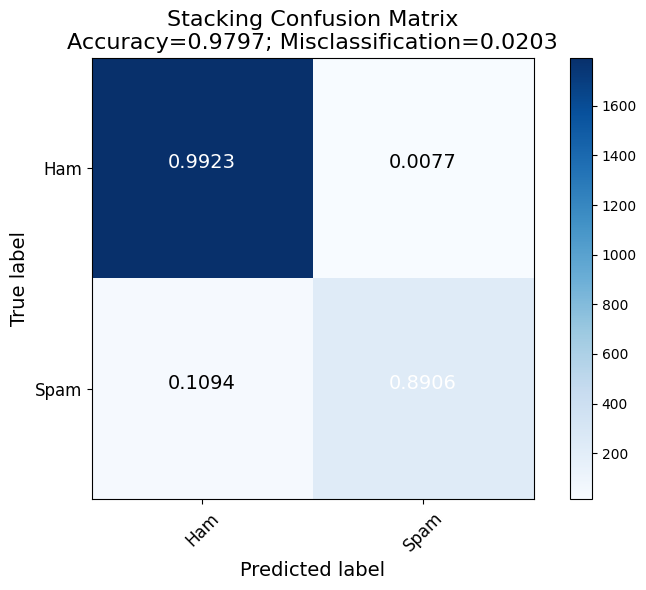

In [ ]:
with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)


X_train_text = np.array(X_train)
X_test_text = np.array(X_test)
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()


X_train_tfidf_all = vectorizer.transform(X_train_text)
X_test_tfidf_all = vectorizer.transform(X_test_text)


n_splits = 3
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
bert_meta = np.zeros(len(y_train_np))
# lstm_meta = np.zeros(len(y_train_np))
rf_meta = np.zeros(len(y_train_np))


for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_text, y_train_np)):


    X_val_text = X_train_text[val_idx]
    X_val_tfidf = X_train_tfidf_all[val_idx]
    y_val = y_train_np[val_idx]

    # ----- BERT -----
    bert_val_probs = get_bert_probs(best_model_bert, X_val_text.tolist())
    bert_meta[val_idx] = bert_val_probs

    # ----- Random Forest -----
    X_tr_text = X_train_text[train_idx]
    X_tr_tfidf = vectorizer.transform(X_tr_text)
    y_tr = y_train_np[train_idx]

    rf = RandomForestClassifier(n_estimators=200, max_depth=20, class_weight='balanced', random_state=42)
    rf.fit(X_tr_tfidf, y_tr)
    rf_val_probs = rf.predict_proba(X_val_tfidf)[:, 1]
    rf_meta[val_idx] = rf_val_probs


X_meta_train = np.vstack([bert_meta, rf_meta]).T
meta_learner = XGBClassifier(n_estimators=100, eval_metric='logloss')
meta_learner.fit(X_meta_train, y_train_np)


bert_test_probs = get_bert_probs(best_model_bert, X_test_text.tolist())
rf_test_probs = best_rf.predict_proba(X_test_tfidf_all)[:, 1]

X_meta_test = np.vstack([bert_test_probs, rf_test_probs]).T
y_pred = meta_learner.predict(X_meta_test)
y_prob = meta_learner.predict_proba(X_meta_test)[:, 1]


print("\nStacking Classifier Evaluation on Test Set:")
print(classification_report(y_test_np, y_pred))
print(f"Accuracy:  {accuracy_score(y_test_np, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_np, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test_np, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test_np, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test_np, y_prob):.4f}")


cm = confusion_matrix(y_test_np, y_pred)
plot_confusion_matrix(cm, target_names=["Ham", "Spam"], title="Stacking Confusion Matrix", normalize=True)

# Intent Classification

In [ ]:
# Load zero-shot classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

# Define candidate intent labels
candidate_labels = [
    "scam", "phishing", "promotion", "subscription",
    "service notification", "malware", "lottery",
    "fake job offers", "fake charity", "adult content",
    "delivery/shipping notification"
]

# Extract all spam messages
spam_messages = df[df["Class"] == "spam"]["Message"]

# Initialize an empty list to store predicted intents
predicted_intents = []

# Classify each spam message with progress bar
for msg in tqdm(spam_messages, desc="Classifying intents"):
    result = classifier(msg, candidate_labels)
    predicted_intents.append(result["labels"][0])  # Save the top label

# Update the original DataFrame with predicted intent labels
df.loc[spam_messages.index, "Predicted Intent"] = predicted_intents

# Display messages and predicted intents
print(df.loc[spam_messages.index, ["Message", "Predicted Intent"]])


In [ ]:
print(df[df["Class"] == "spam"]["Predicted Intent"].value_counts())

In [ ]:
# Ensure only classified spam messages are selected
df_spam_with_intent = df[df["Class"] == "spam"].dropna(subset=["Predicted Intent"])

# Group by intent and take the first message from each group
sample_messages = df_spam_with_intent.groupby("Predicted Intent").first()[["Message"]]

# Print one example message for each predicted intent
for intent, row in sample_messages.iterrows():
    print(f"Intent: {intent}")
    print(f"Message: {row['Message']}")
    print("-" * 80)